In [1]:
import torch
import numpy as np
from box import Box
import matplotlib.pyplot as plt

from GraphPreCo import get_model
from src.utils.PreCo.load_data import load_data, load_validate_data

from src.model.get_model import get_reparam_multi_linear_model
from src.utils.load_data import load_data as load_data_multistep_linear
from src.utils.data_preprocess import get_data

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

Using backend: pytorch


cpu


In [2]:
def plot_ICPreCo(file_src, data_src):
    config_filename = 'model/ICPreCo/model_config.yaml'
    config = Box.from_yaml(filename=config_filename)
    m = get_model(config).to(device)
    model_filename = 'model/ICPreCo/model.pt'
    m.load_state_dict(torch.load(model_filename, map_location=device))
    m.eval()

    history_len = config.train.history_len  # 20
    future_len = config.train.future_len  # 20
    future_len = 10  # 10
    action_ws = config.data.action_ws if config.data.get('action_ws') else True

    _, _, _, _, train_info = load_data(paths=config.data.train_path,
                                       history_len=history_len,
                                       future_len=future_len,
                                       action_ws=action_ws,
                                       scaling=config.data.scaling)

    hist_x, future_x, hist_u, future_u, _ = load_validate_data(paths=file_src,
                                                               history_len=history_len,
                                                               future_len=future_len,
                                                               action_ws=action_ws,
                                                               scaling=False,
                                                               device=device)
    data = torch.load(data_src, map_location=device)
    print(data.shape)
    print(future_u.shape)
    dif = data[:, :, 0, 0] - future_u[:, :, 0, 0]
    dif = dif.cpu().detach().numpy()
    plt.plot(dif)
    plt.show()

In [3]:
def plot_multistep_linear(file_src, horizon, data_src):
    state_dim = 140
    action_dim = 40
    state_order = 5
    action_order = 5
    alpha = 0.001  # Workset smoothness
    time_limit = 5  # seconds
    train_data_path = ['docs/new_data/expert/data_1.csv', 'docs/new_data/expert/data_2.csv']

    m = get_reparam_multi_linear_model(state_dim, action_dim, state_order, action_order)
    model_filename = 'model/Multistep_linear/model_reparam_55.pt'
    m.load_state_dict(torch.load(model_filename, map_location=device))
    m.eval()

    train_states, train_actions, info = load_data_multistep_linear(paths=train_data_path,
                                                                   scaling=True,
                                                                   preprocess=True,
                                                                   history_x=state_order,
                                                                   history_u=action_order)
    scaler = (info['scale_min'].item(), info['scale_max'].item())
    #print(train_states[0].shape)
    #print(train_actions[0].shape)
    #print('Min. state scaler: {}, Max. state scaler: {}'.format(scaler[0], scaler[1]))
    #print('Min. action scaler: {}, Max. action scaler: {}'.format(scaler[0], scaler[1]))

    validate_states, validate_actions, _ = load_data_multistep_linear(paths=file_src,
                                                                      scaling=False,
                                                                      preprocess=True,
                                                                      history_x=state_order,
                                                                      history_u=action_order,
                                                                      device=device)
    validate_states = validate_states[0][:, :state_dim]
    validate_actions = validate_actions[0]
    data = torch.load(data_src, map_location=device)
    print(data.shape)
    print(validate_actions.shape)
    dif = data[:, 0, ] - validate_actions[:data.shape[0],:]
    dif = dif.cpu().detach().numpy()
    plt.plot(dif)
    plt.show()

torch.Size([896, 40, 1, 1])
torch.Size([896, 40, 10, 1])


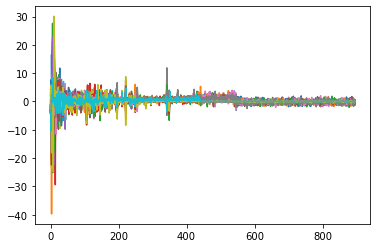

torch.Size([898, 1, 40])
torch.Size([911, 40])


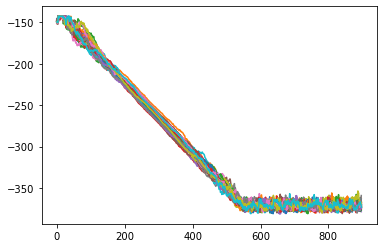

torch.Size([858, 1, 40])
torch.Size([911, 40])


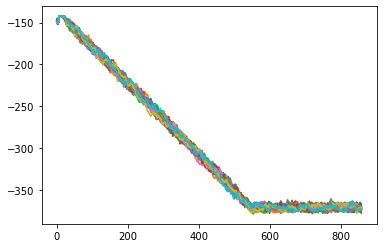

torch.Size([833, 1, 40])
torch.Size([911, 40])


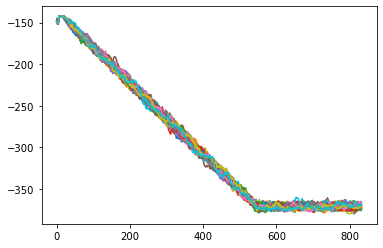

In [4]:
ICPreCo_src = 'experiment_result/ICPreCo_01.csv'
ICPreCo_workset_src = 'validate_workset/ICPreCo_01_WS.pt'

multistep_linear_src = ['experiment_result/Multistep_Linear_01.csv', 'experiment_result/Multistep_Linear_02.csv',
                         'experiment_result/Multistep_Linear_03.csv']
Hs = [10, 50, 75]
multistep_linear_workset_src = ['validate_workset/multistep_linear_10_WS.pt', 'validate_workset/multistep_linear_50_WS.pt',
                                'validate_workset/multistep_linear_75_WS.pt']
plot_ICPreCo(ICPreCo_src, ICPreCo_workset_src)
for i in range(len(Hs)):
    plot_multistep_linear(multistep_linear_src[i], Hs[i], multistep_linear_workset_src[i])
